# Impact of Dams on Streamflow

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import proplot as pplt
import pygeohydro as gh
from pygeohydro import NID, NWIS
from pynhd import NLDI, WaterData, ZeroMatched

The primary goal of this hands-on tutorial is to introduce a handful of geospatial web services for conducting scientific studies. For this purpose, we're going to take a look at the effects of building dams on streamflows. Here are some example peer-reviewed papers on this topic.

- https://doi.org/10.5194/hess-17-3189-2013
- https://doi.org/10.1002/2017WR020871

We set the area of interest (AOI) for this study to Texas and study dams that have been built in the 1995-2005 period.

## Streamflow Gauges

First, we use the National Water Information System (NWIS) service to check streamflow data availability in our AOI, Texas, and 10 years before and after the period of our study, i.e., the 1985-2015 period.

In [2]:
start = "1985-01-01"
end = "2015-01-01"
texas = gh.helpers.get_us_states("contiguous")
texas = texas[texas.STUSPS == "TX"]

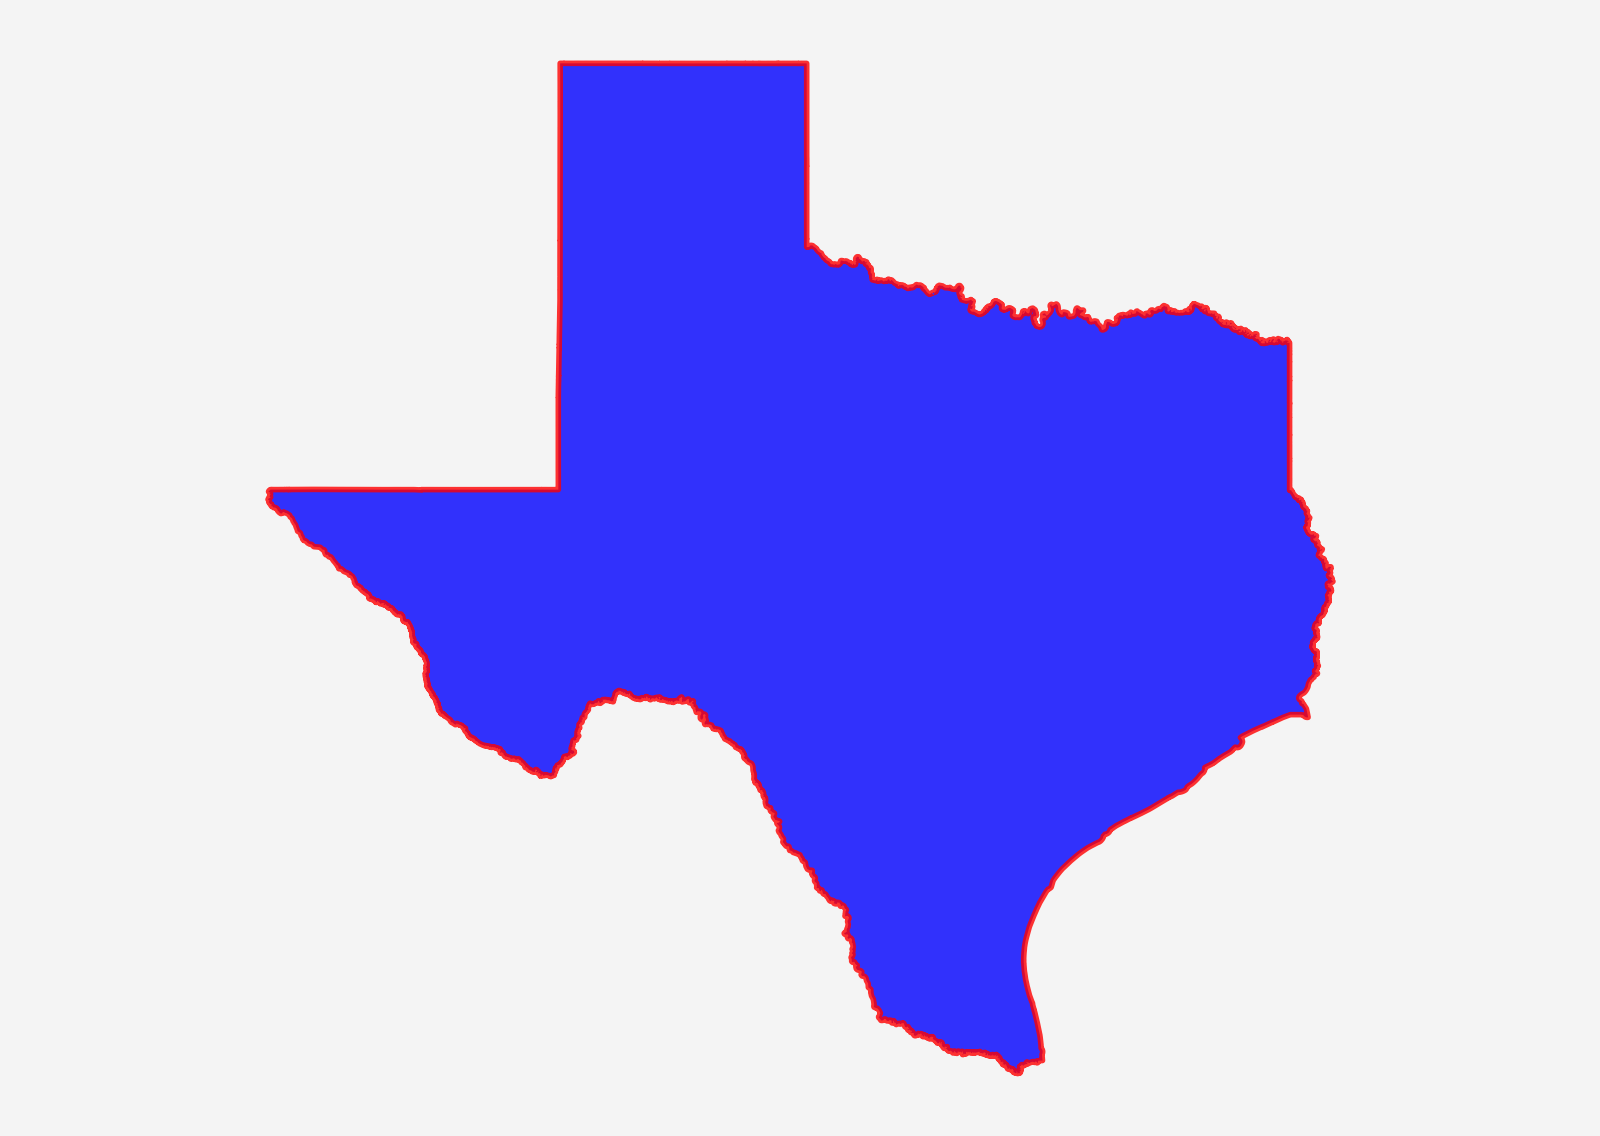

In [3]:
_, ax = pplt.subplots(refwidth=8)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
ax.set_axis_off()

In [4]:
nwis = NWIS()
query = {
    "stateCd": "TX",
    "startDt": start,
    "endDt": end,
    "outputDataTypeCd": "dv",  # daily values
    "hasDataTypeCd": "dv",  # daily values
    "parameterCd": "00060",  # discharge
}
sites = nwis.get_info(query)
sites.shape[0]

3856

We can see that there are 3856 streamflow gauge stations in Texas that fit our criteria.

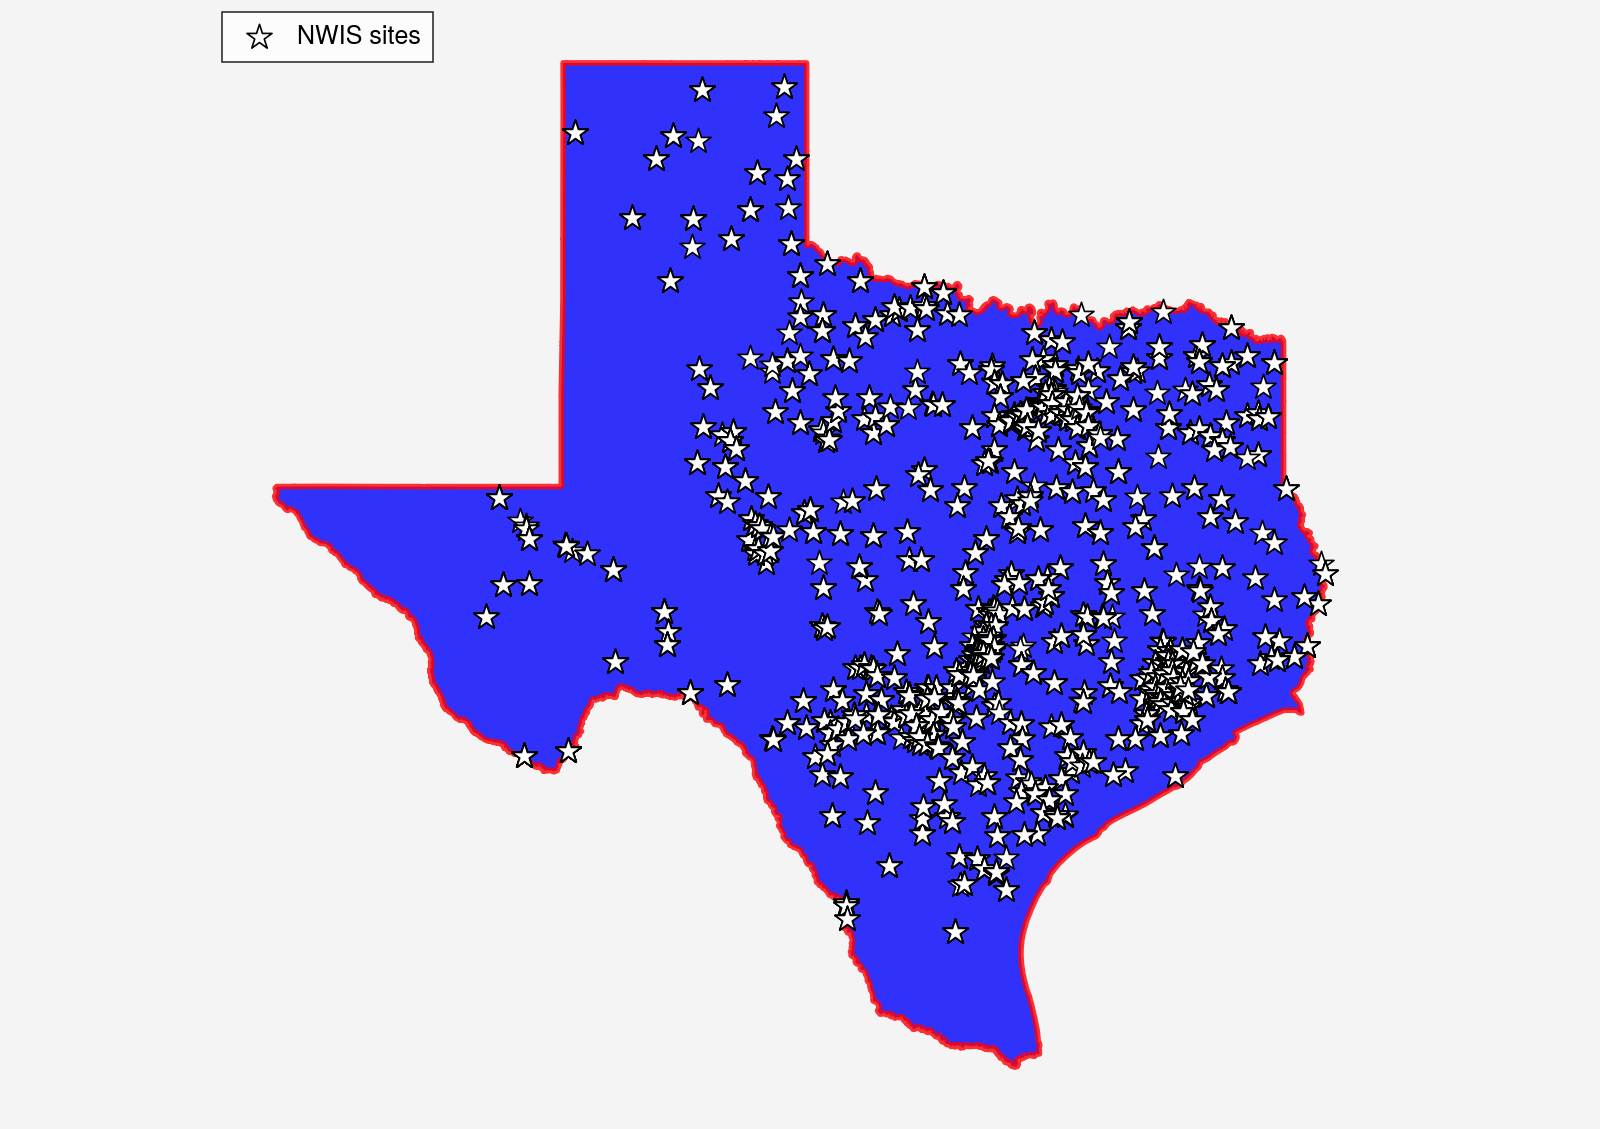

In [5]:
_, ax = pplt.subplots(refwidth=8)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

Now, let's filter these stations a step further to include only those stations that have around 30 years of daily streamflow data with drainage area of larger than 10 km$^2$ that have been impacted by human activies.

In [6]:
sites = sites[
    (sites.parm_cd == "00060")  # discharge
    & (sites.stat_cd == "00003")  # mean
    & (sites.count_nu >= 30 * 365)  # at least 30 years of data
    & ~sites.hcdn_2009  # not pristine
    & (sites.drain_sqkm > 10)
].copy()
sites.shape[0]

280

Upon applying this filter, we're left with 280 stations.

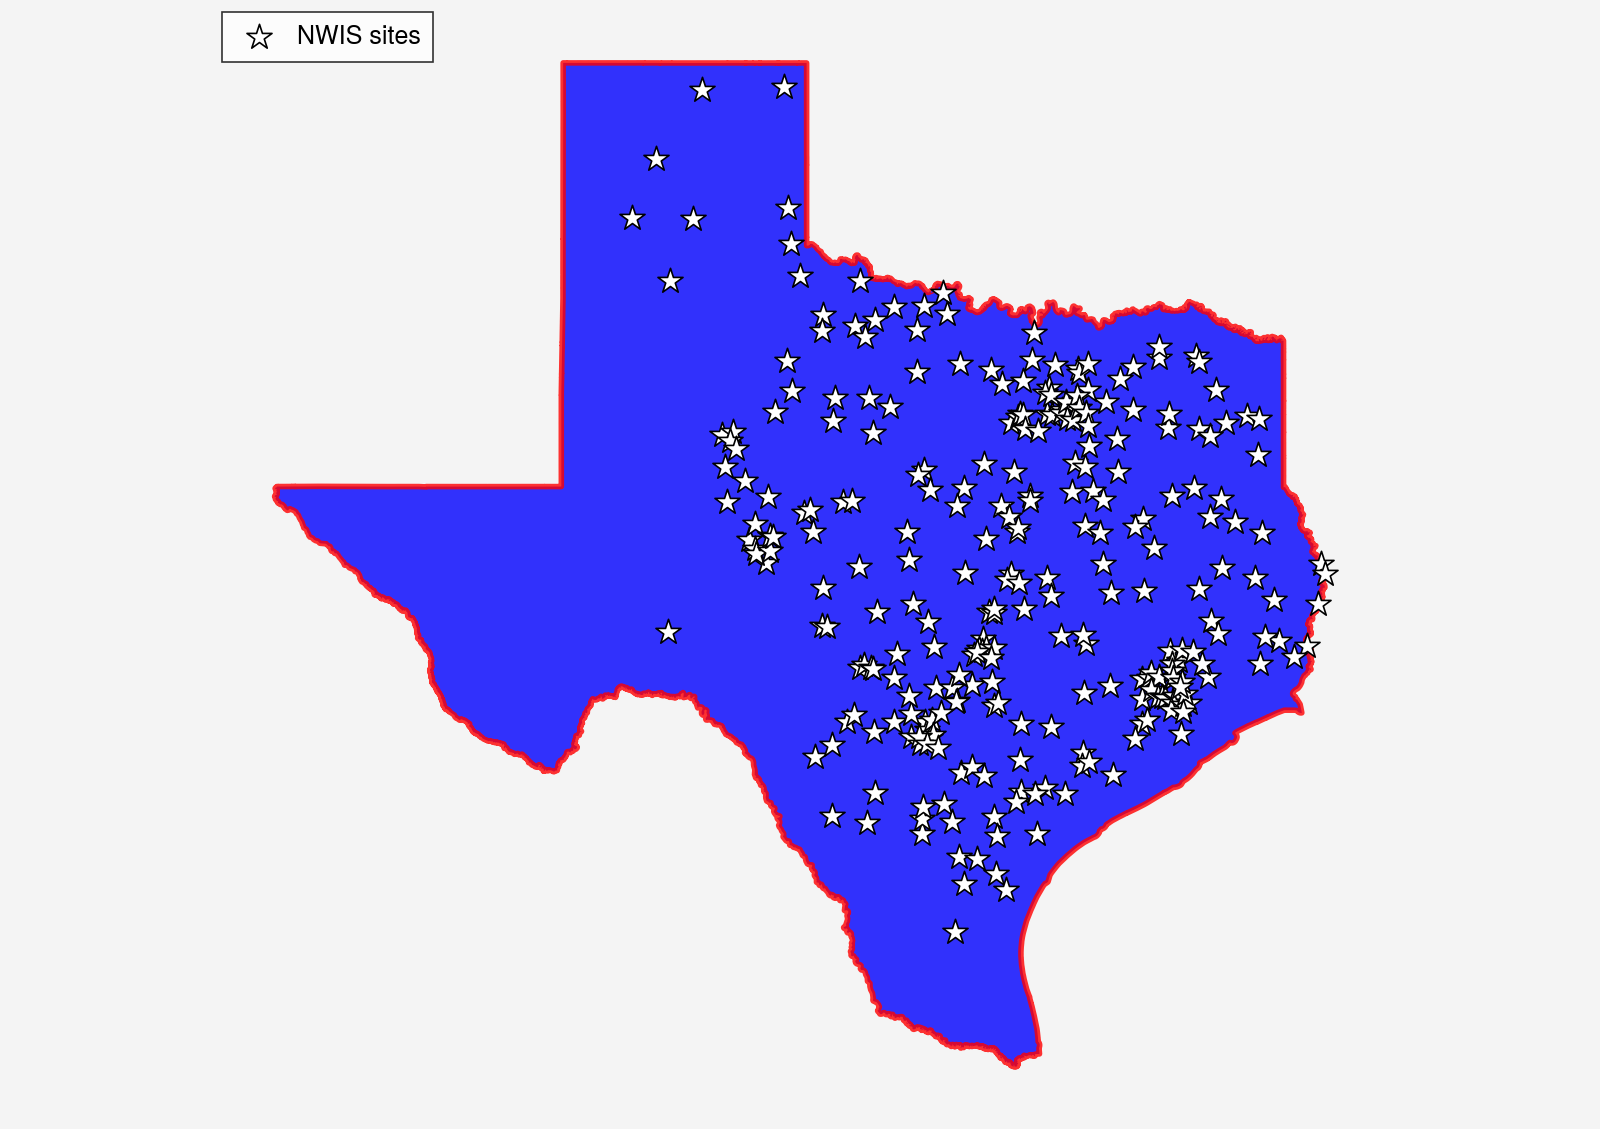

In [7]:
_, ax = pplt.subplots(refwidth=8)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=90, color="w", edgecolor="k", label="NWIS sites")
ax.legend(loc="upper left")
ax.set_axis_off()

## Dams

Next, we need to retrieve the dams in Texas that have been built between 1995 and 2005. We use National Inventory of Dams (NID) web service for this purpose. First, let's check out the fields that NID exposes through their web service.

In [8]:
nid = NID()
nid.valid_fields[nid.valid_fields.str.contains("year", case=False)]

70      yearCompleted
71    yearCompletedId
83      yearsModified
Name: name, dtype: object

In [9]:
nid.valid_fields[nid.valid_fields.str.contains("state", case=False)]

13                stateFedId
17          stateRegulatedId
19     stateRegulatoryAgency
30                     state
31                 cityState
38               countyState
192                 statesId
194                 stateKey
Name: name, dtype: object

Based on these, we should use the ``stateKey`` and ``yearCompleted`` fields.

In [10]:
dam_list = nid.get_byfilter(
    [
        {
            "stateKey": ["TX"],
            "yearCompleted": ["[1995 2005]"],
        },
    ],
)
dams = dam_list[0]

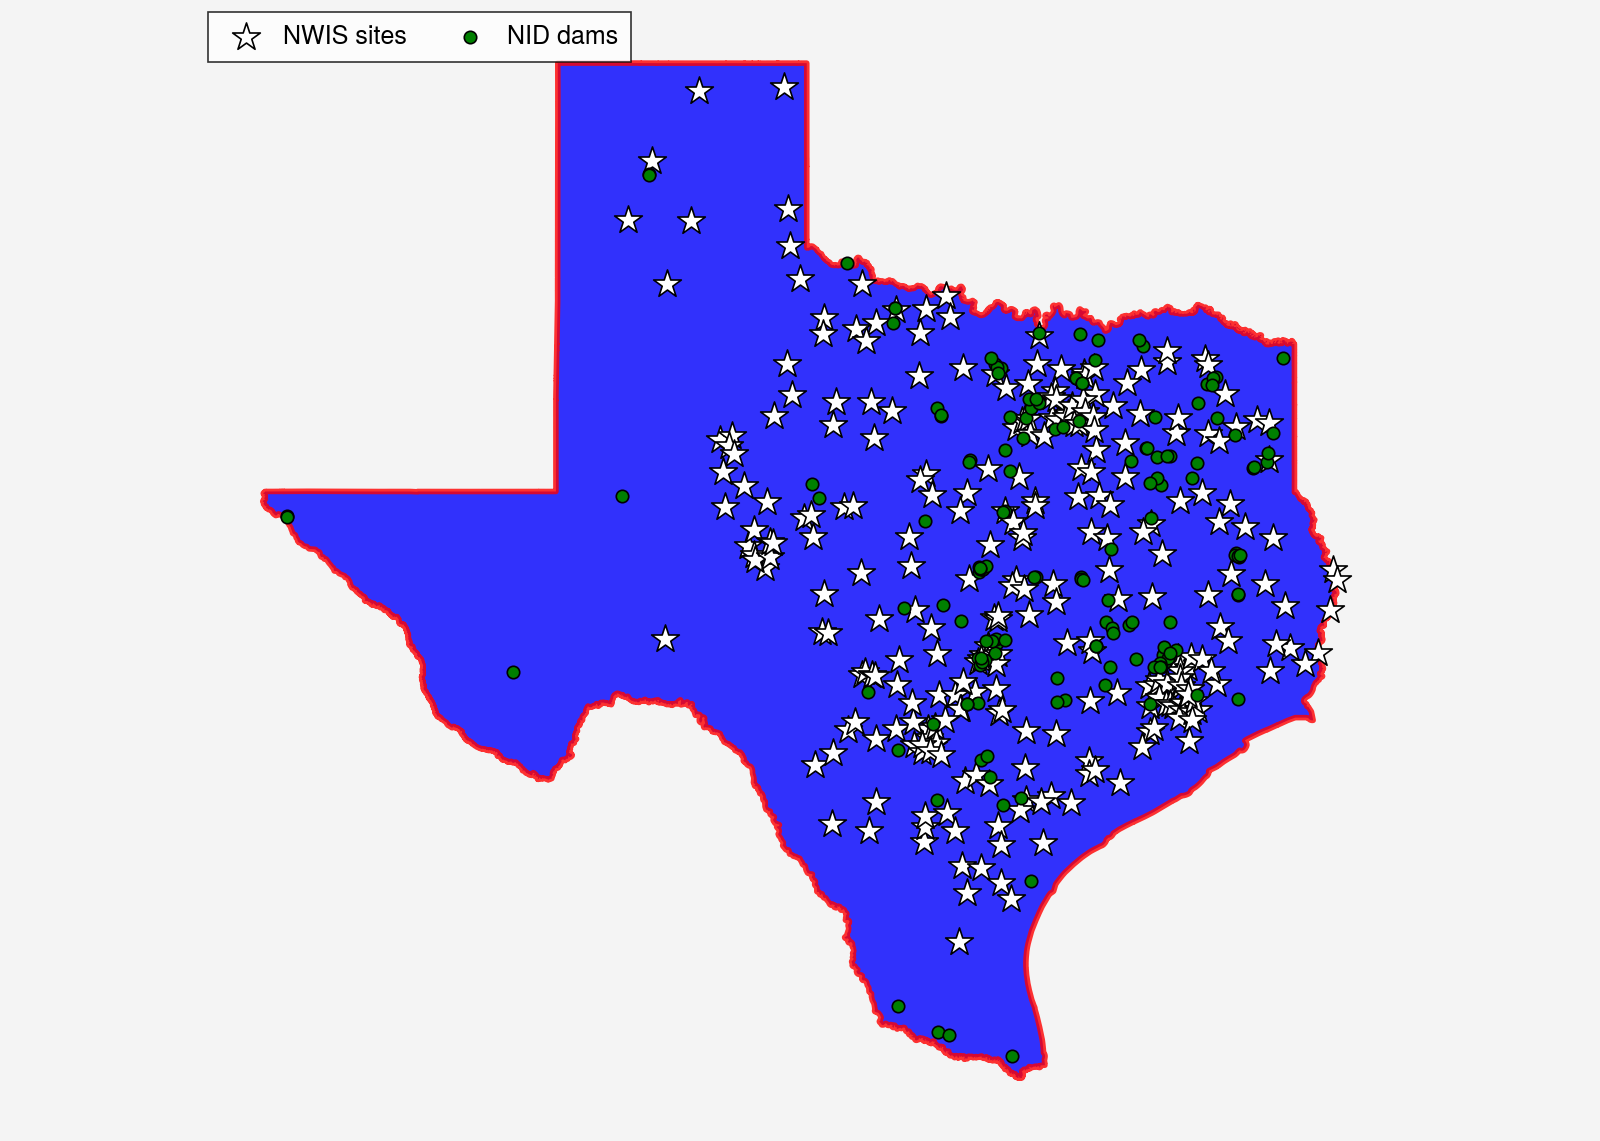

In [11]:
_, ax = pplt.subplots(refwidth=8)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

As is evident from the plot above, there are many stations that don't have any dams in their vicinity. One way to eliminate these stations is using a spatial query based on a search radius. We can determine an estimation for our search radius based on the upstream drainage area distribution of the streamflow gauges.

array([[<AxesSubplot:title={'center':'drain_sqkm'}>]], dtype=object)

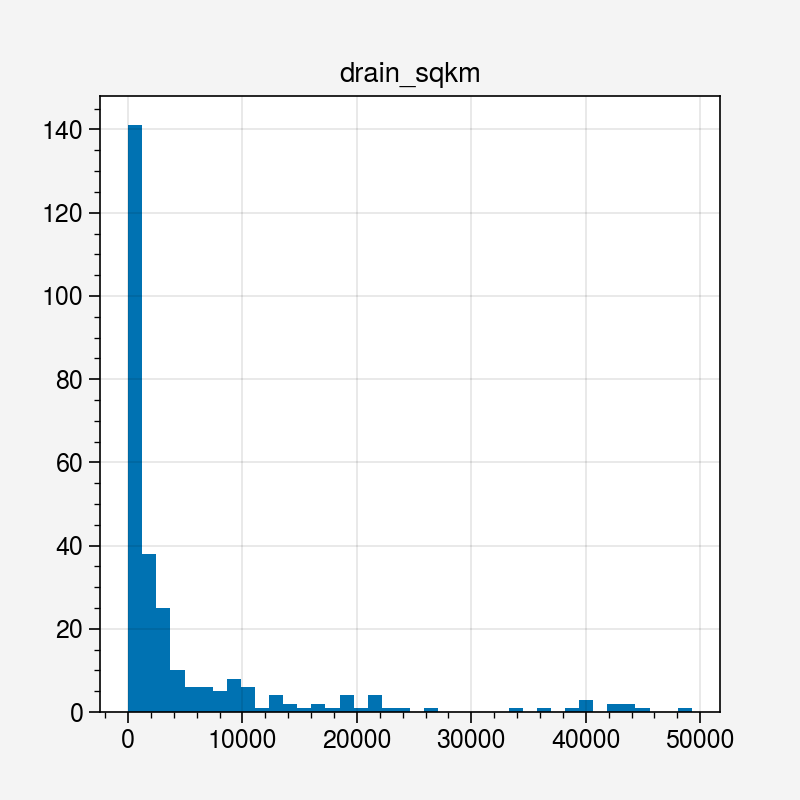

In [12]:
sites.hist("drain_sqkm", bins="auto")

We can see that most stations have a drainage area of less than 15000 km$^2$. Since they're not very large a search radius of 10 km should be sufficient. Now, we define a function that carries out an efficient spatial query to find the stations that have at least one dam within a 10-km radius.

In [13]:
def distance_filter(gdf1, gdf2, dist_km):
    """Filter gdf1 to only include points within distance of gdf2."""
    buff = gdf1.to_crs(5070).buffer(dist_km * 1e3)
    idx2, idx1 = buff.sindex.query_bulk(gdf2.to_crs(5070).geometry)
    return gdf1.iloc[pd.unique(idx1)].reset_index(drop=True), gdf2.iloc[
        pd.unique(idx2)
    ].reset_index(drop=True)

array([[<AxesSubplot:title={'center':'drain_sqkm'}>]], dtype=object)

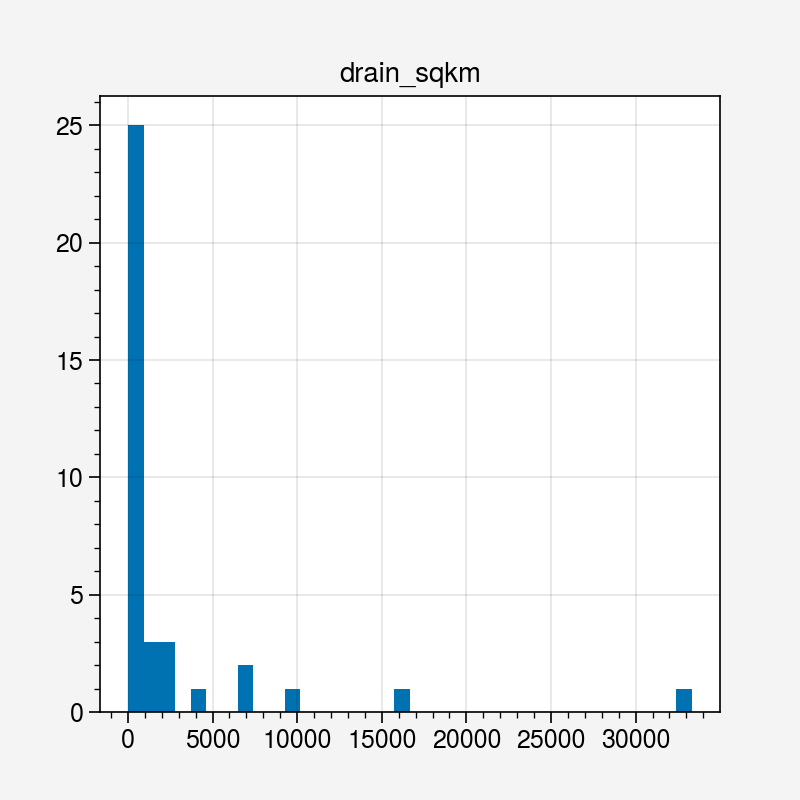

In [14]:
sites, dams = distance_filter(sites, dams, 10)

sites.hist("drain_sqkm", bins="auto")

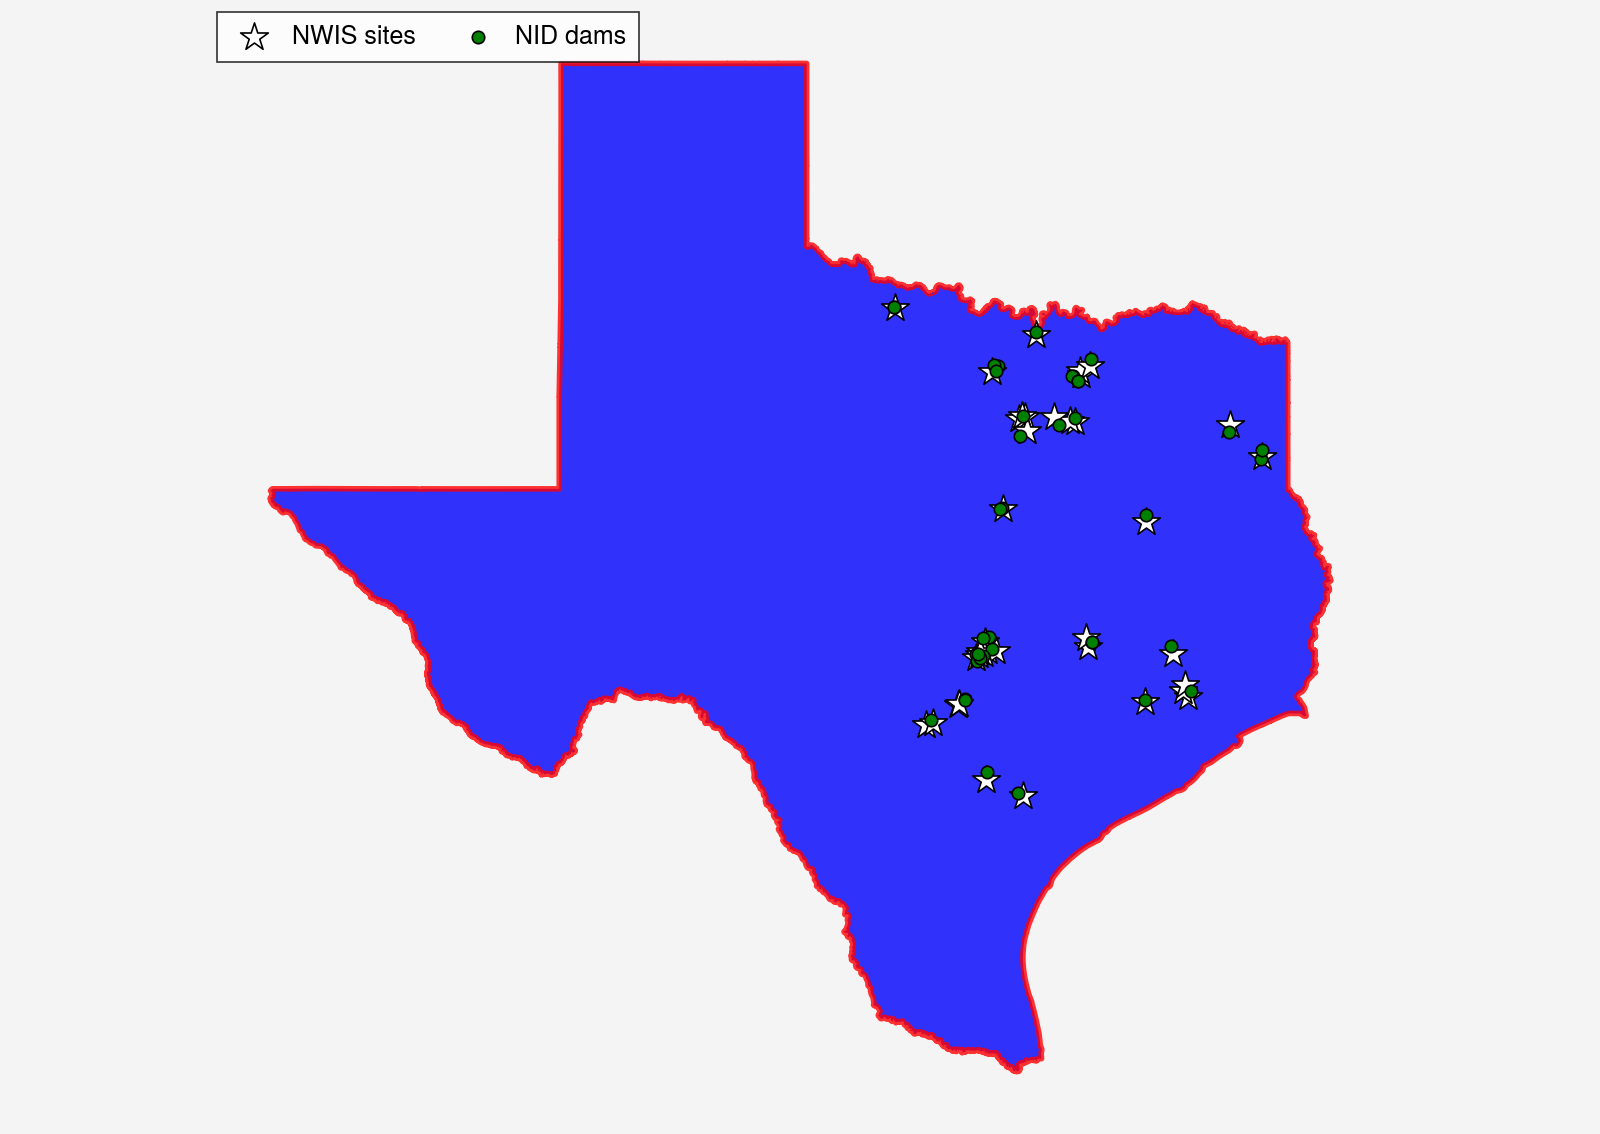

In [15]:
_, ax = pplt.subplots(refwidth=8)
texas.plot(ax=ax, facecolor="b", edgecolor="r", linewidth=2, alpha=0.8, figsize=(10, 10))
sites.plot(ax=ax, marker="*", markersize=110, color="w", edgecolor="k", label="NWIS sites")
dams.plot(ax=ax, marker="o", markersize=20, color="g", edgecolor="k", label="NID dams")
ax.legend(loc="upper left")
ax.set_axis_off()

## Flowlines and Hydrolinking

So far, we obtained only the stations that have at least one dam in their 10-km radius, but we didn't find if those dams are in their upstream or downstream. We use the Hydro Network-Linked Data Index (NLDI) web service to obtain the upstream flowlines of the streamflow gauges up to 10 km. Note that this 10 km is the distance along the flowlines.

In [16]:
nldi = NLDI()

In [17]:
flw_up = {}
noflw = []
for agency, fid in sites[["agency_cd", "site_no"]].itertuples(index=False, name=None):
    try:
        flw_up[fid] = nldi.navigate_byid(
            fsource="nwissite",
            fid=f"{agency}-{fid}",
            navigation="upstreamTributaries",
            source="flowlines",
            distance=10,
        )
    except ZeroMatched:
        noflw.append(fid)

In [18]:
noflw

['08058900', '08059400']

Note that two of our stations are not indexed by the NLDI service. There could be several reasons for this but in this tutorial we just simply ignore them.

In [19]:
sites = sites[sites.site_no.isin(flw_up)].copy()
sites, dams = distance_filter(sites, dams, 10)

We now have flowlines and dams that are closer than 10 km but we still don't have a way of linking these features. For this purpose, we use NHDPlus's Common Identifier (`comid`). One way to obtain the first downstream flowine of coordinate is to use NLDI's `hydrolocation` endpoint.

In [20]:
coords = list(dams[["longitude", "latitude"]].astype(float).itertuples(index=False, name=None))
nid_comids = nldi.comid_byloc(coords)
dams["nhdplus_comid"] = nid_comids.comid

coords = list(sites[["dec_long_va", "dec_lat_va"]].astype(float).itertuples(index=False, name=None))
site_comids = nldi.comid_byloc(coords)
sites["nhdplus_comid"] = site_comids.comid

We can then use these obtained comids to hydrolink the dams, stations, and flowlines.

In [21]:
flw_all = pd.concat(flw_up.values(), keys=flw_up.keys()).reset_index().drop(columns="level_1")
flw_all = gpd.GeoDataFrame(
    flw_all.rename(columns={"level_0": "usgs_id"}), crs=flw_up["07312200"].crs
)
flw_all.head()

,usgs_id,geometry,nhdplus_comid
0,07312200,"LINESTRING (-98.91447 33.90670, -98.91436 33.9...",13730379
1,07312200,"LINESTRING (-98.98054 33.88001, -98.98019 33.8...",13730385
2,07312200,"LINESTRING (-98.90898 33.91041, -98.90892 33.9...",13730365
3,07312200,"LINESTRING (-98.92151 33.91425, -98.92038 33.9...",13730363
4,07312200,"LINESTRING (-98.90453 33.92514, -98.90453 33.9...",13730361


Finally, upon hydrolinking these features we can determine the stations that have at least one dam in their upstream up to 10 km.

In [22]:
flw_dam = pd.merge(
    flw_all[["usgs_id", "nhdplus_comid"]],
    dams[["id", "nhdplus_comid"]].rename(columns={"id": "dam_id"}),
    on="nhdplus_comid",
    how="left",
)
flw_dam = flw_dam[~flw_dam.dam_id.isna()].reset_index(drop=True)
flw_dam["dam_id"] = flw_dam.dam_id.astype(int)
flw_dam

,usgs_id,nhdplus_comid,dam_id
0,07312200,13730353,543785
1,07312200,13730353,543855
2,08095000,5531532,544204
3,08095000,5531532,544213
4,08158920,5781345,542221
5,08158920,5781345,543202
6,08057445,1260363,543218
7,08177300,1638809,544499
8,08178700,10839872,542209


In [23]:
site_dam = flw_dam.usgs_id.unique()
site_dam

array(['07312200', '08095000', '08158920', '08057445', '08177300',
       '08178700'], dtype=object)

## Streamflow Observations

Upon finalizing the stations that satisfy our criteria, we use NWIS to obtain the daily streamflow data. But first, we need to obtain the year that the construction of dams were completed, so we can exactly specify the required streamflow data period.

In [24]:
dams_info = nid.inventory_byid(flw_dam.dam_id.to_list())
dams_info.head()

,id,associatedStructuresCount,conditionAssessDate,conditionAssessDetail,conditionAssessId,congRepresentative,damHeight,damLength,distance,drainageArea,...,ownerTypeIds,primaryDamTypeId,primaryOwnerTypeId,primaryPurposeId,purposeIds,dsacId,femaRegion,lastEapExcerDate,dataUpdated,geometry
0,543785,0,None,NOT RATED,6,Mac Thornberry (R),29.0,983,20,0.00,...,1,8,1,2,2,None,6,None,2021-05-24T12:00:00.000Z,POINT (-98.91833 33.92000)
1,543855,0,None,NOT RATED,5,Mac Thornberry (R),27.0,0,0,0.20,...,1,8,1,2,2,None,6,None,2018-07-23T12:00:00.000Z,POINT (-98.91696 33.92299)
2,544204,0,None,NOT RATED,5,Roger Williams (R),18.6,130,0,150.00,...,5,11,5,2,2;8,None,6,None,2018-07-23T12:00:00.000Z,POINT (-97.57644 31.79505)
3,544213,0,2015-12-14T12:00:00.000Z,SATISFACTORY,1,Roger Williams (R),47.0,1300,0,0.36,...,5,8,5,8,8,None,6,None,2018-07-23T12:00:00.000Z,POINT (-97.60174 31.78104)
4,542221,0,2016-10-13T12:00:00.000Z,POOR,3,Chip Roy (R),26.0,730,0,1.34,...,5,4,5,9,9,None,6,None,2018-07-23T12:00:00.000Z,POINT (-97.89934 30.24614)


We use the `yearCompleted` field to determine the required study period by looking at 15 years before and after the year completed for each dam. The reason that we opted for 15 years is the fact that during the construction the streamflow is temporarily diverted from its original path and also upon completion it usually takes some time for dams to be filled and reach their operational capacity. So we consider a 5-year buffer around the year completed.

In [25]:
flw_dam = pd.merge(
    flw_dam,
    dams_info[["id", "nidStorage", "nidHeight", "yearCompleted"]].rename(columns={"id": "dam_id"}),
    on="dam_id",
    how="left",
)
flw_dam["start"] = pd.to_datetime(flw_dam.yearCompleted - 15, format="%Y")
flw_dam["end"] = pd.to_datetime(flw_dam.yearCompleted + 15, format="%Y") + pd.DateOffset(
    years=1, days=-1
)

We then use these dates to obtain the streamflow.

In [26]:
dates = (flw_dam.start.min(), flw_dam.end.max())
qobs = nwis.get_streamflow(site_dam, dates)

Now, let's take a look at the data and assess the station by visual inspection. Note the there are several methods for quantifying the impact of dams on streamflow such as Reservoir Index, but in this tutorial we just rely on visual inspection for brevity.

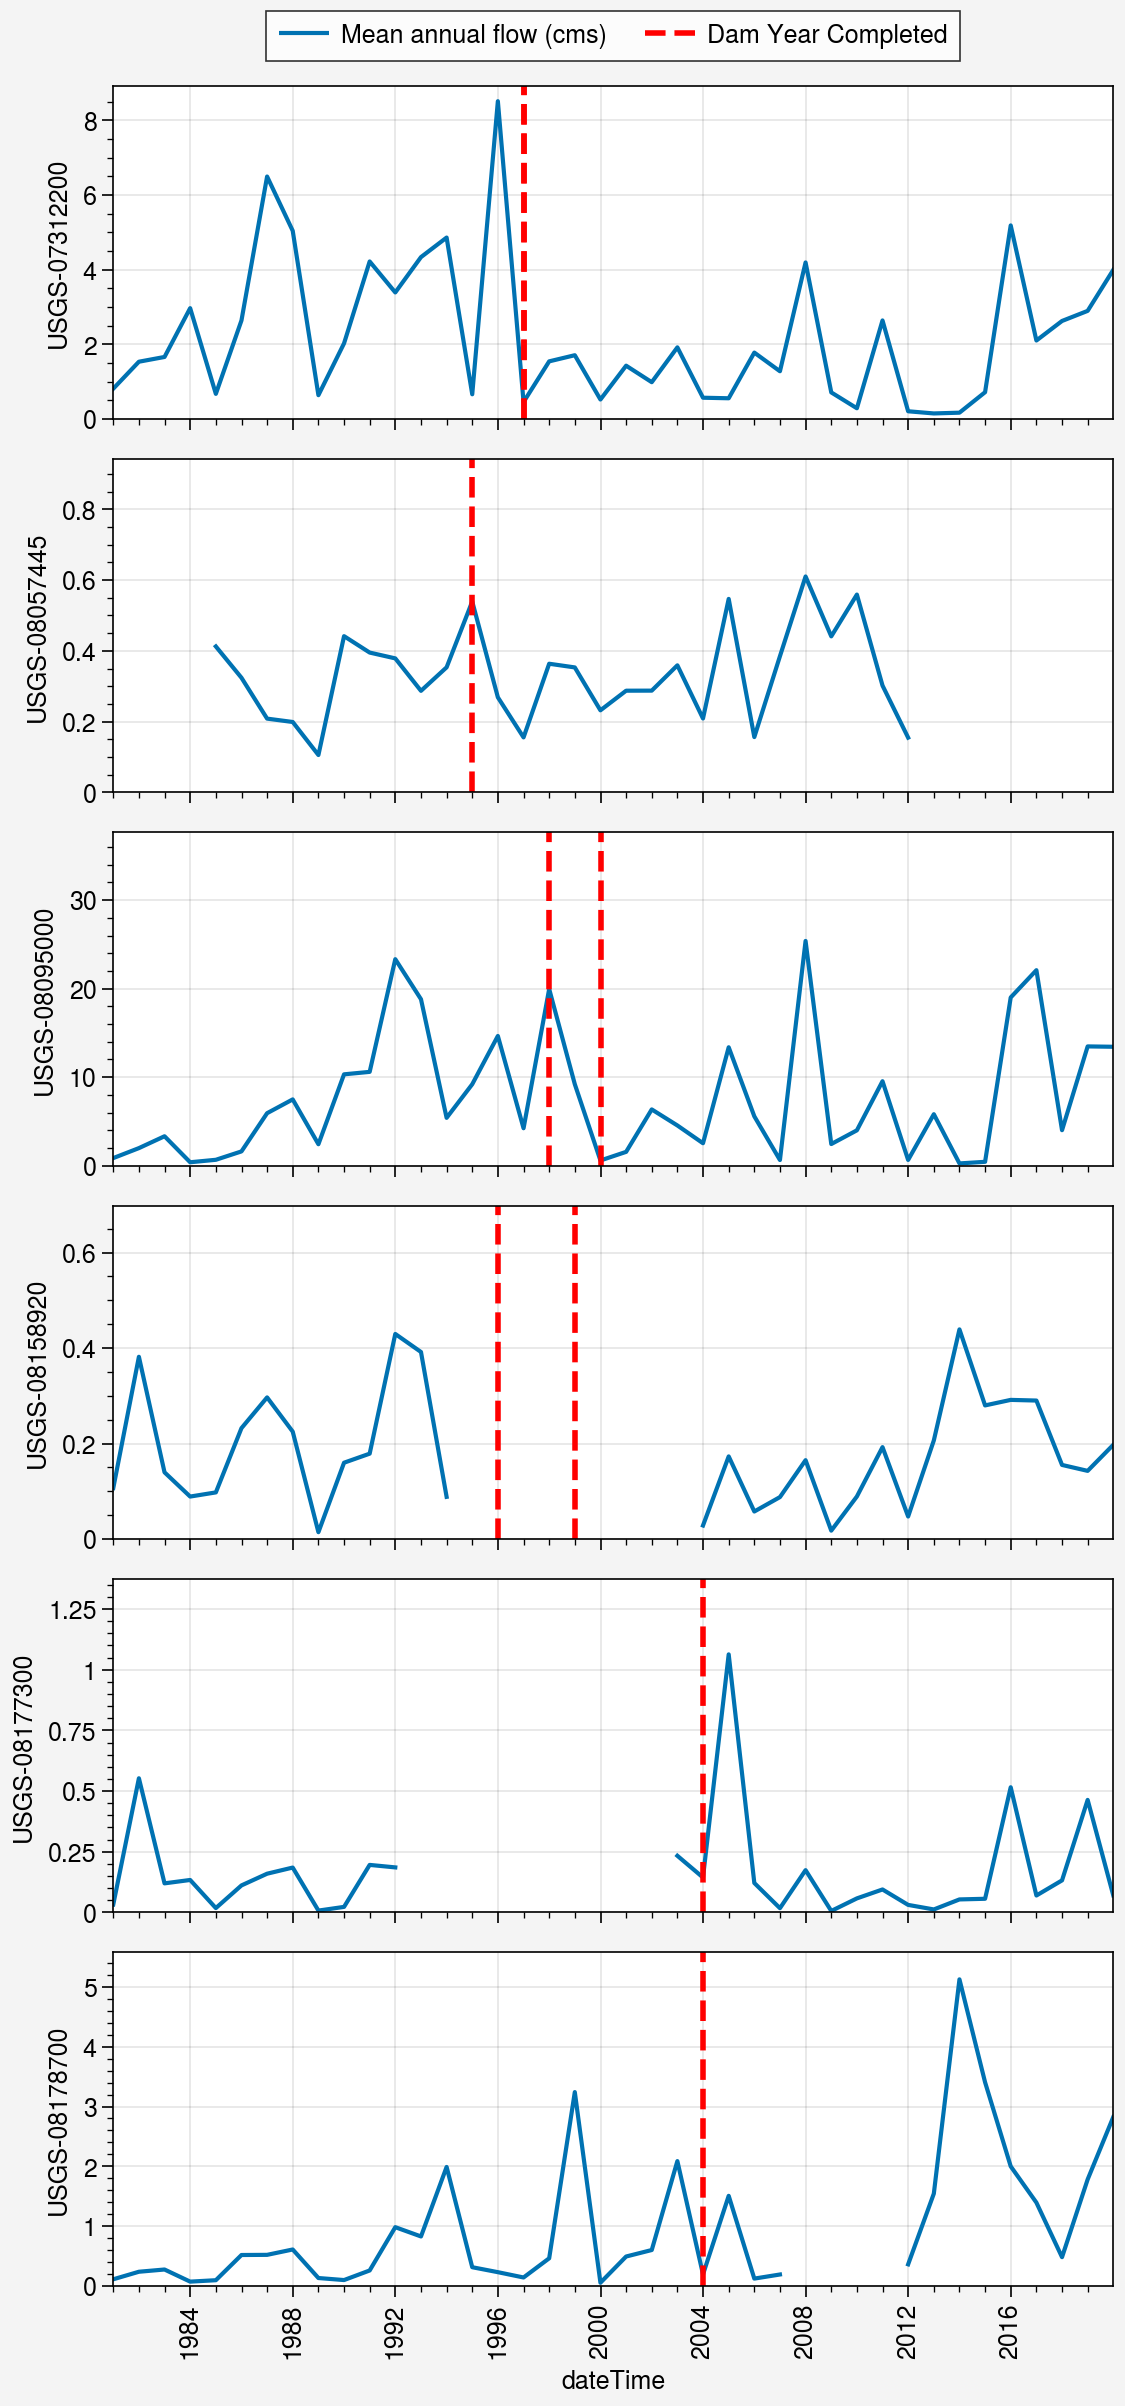

In [27]:
ma = qobs.groupby(pd.Grouper(freq="Y")).mean()
yc = flw_dam.set_index("usgs_id").yearCompleted
fig, axs = pplt.subplots(nrows=ma.shape[1], refwidth=5, refaspect=3, sharex=True, sharey=False)

hs = [0, 1]
for i, s in enumerate(ma):
    hs[0] = axs[i].plot(ma[s], label="Mean annual flow (cms)")
    axs[i].format(ylim=(0, ma[s].quantile(0.95) * 1.7), ylabel=s)
    yrs = yc.loc[s.replace("USGS-", "")]
    yrs = [yrs] if isinstance(yrs, np.int64) else yrs
    for yr in yrs:
        hs[1] = axs[i].axvline(pd.to_datetime(yr, format="%Y"), color="r", linestyle="--", linewidth=2, label="Dam Year Completed")
fig.legend(hs, loc="t")

We can see that based on the available data and visual inspection, the first station shows a noticeable difference before and after the dam construction. Next we take a closer look at this station, `USGS-07312200`.

## Land Use/Land Cover (LULC)

To gain a better understanding of the land features around and near the `USGS-07312200` station and its dams, we use the LULC data. For this purpose, first, we need to obtain the local catchments up to 10 km upstream of the station. The WaterData web service has several layers on eof which is local catchments. Let's use the comids to obtain their corresponding catchments.

In [28]:
station_id = ma.columns[0].replace("USGS-", "")
wd = WaterData("catchmentsp")
catchment = wd.byid("featureid", flw_up[station_id].nhdplus_comid.to_list())

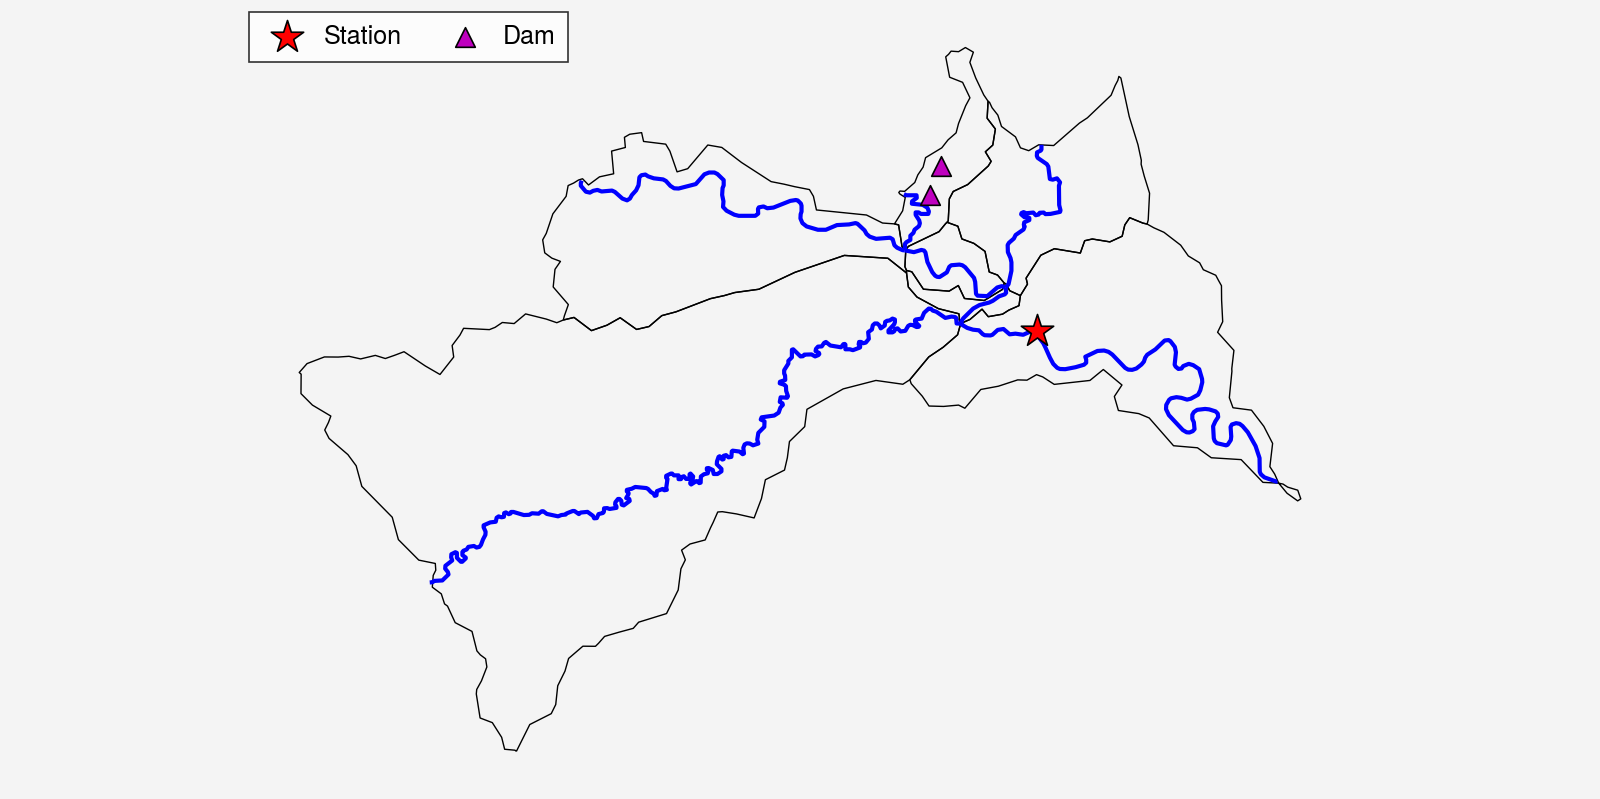

In [29]:
_, ax = pplt.subplots(refwidth=8)
catchment.plot(ax=ax, facecolor="none", edgecolor="k", lw=0.5)
flw_up[station_id].plot(ax=ax, color="b", linewidth=1.5, zorder=1)
sites[sites.site_no.isin([station_id])].plot(ax=ax, edgecolor="k", c="r", marker="*", ms=150, label="Station")
dams[dams.nhdplus_comid.isin(flw_up[station_id].nhdplus_comid)].plot(
    ax=ax, edgecolor="k", c="m", marker="^", ms=50, label="Dam"
)
ax.legend(loc="upper left")
ax.set_axis_off()

Now, we can retrieve the LULC data at 30-m resolution within the union of these catchments using the Multi-Resolution Land Characteristics (MRLC) Consortium web service.

In [30]:
geom = gpd.GeoSeries([catchment.unary_union], crs=catchment.crs, index=[station_id])
nlcd = gh.nlcd_bygeom(geom, 30)[station_id]
nlcd

<xarray.Dataset>
Dimensions:          (y: 268, x: 383)
Coordinates:
  * y                (y) float64 33.94 33.93 33.93 33.93 ... 33.86 33.86 33.86
  * x                (x) float64 -99.0 -99.0 -99.0 ... -98.87 -98.87 -98.87
    spatial_ref      int64 0
Data variables:
    canopy_2016      (y, x) float32 dask.array<chunksize=(268, 383), meta=np.ndarray>
    impervious_2019  (y, x) float32 dask.array<chunksize=(268, 383), meta=np.ndarray>
    descriptor_2019  (y, x) uint8 dask.array<chunksize=(268, 383), meta=np.ndarray>
    cover_2019       (y, x) uint8 dask.array<chunksize=(268, 383), meta=np.ndarray>

In [31]:
meta = gh.helpers.nlcd_helper()
pd.Series(meta["classes"])

11     Open Water - All areas of open water, generall...
12     Perennial Ice/Snow - All areas characterized b...
21     Developed, Open Space - Includes areas with a ...
22     Developed, Low Intensity -Includes areas with ...
23     Developed, Medium Intensity - Includes areas w...
24     Developed, High Intensity - Includes highly de...
31     Barren Land (Rock/Sand/Clay) - Barren areas of...
41     Deciduous Forest - Areas dominated by trees ge...
42     Evergreen Forest - Areas dominated by trees ge...
43     Mixed Forest - Areas dominated by trees genera...
45     Shrub-Forest - Areas identified as currently s...
46     Herbaceous-Forest - Areas identified as curren...
51     Dwarf Scrub - Alaska only areas dominated by s...
52     Shrub/Scrub - Areas dominated by shrubs; less ...
71     Grassland/Herbaceous - Areas dominated by gram...
72     Sedge/Herbaceous - Alaska only areas dominated...
73     Lichens - Alaska only areas dominated by fruti...
74     Moss - Alaska only areas

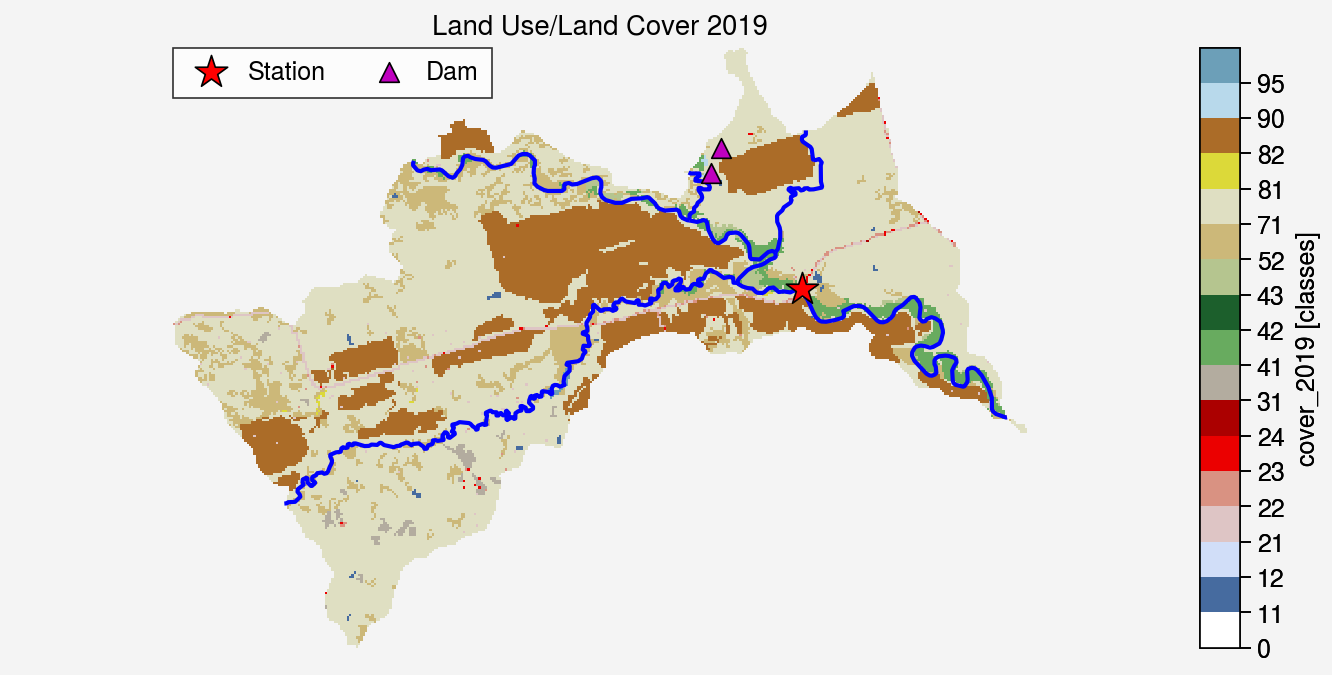

In [32]:
cmap, norm, levels = gh.plot.cover_legends()
_, ax = pplt.subplots(refwidth=6, refaspect=2)
nlcd.cover_2019.plot(ax=ax, cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Land Use/Land Cover 2019")
flw_up[station_id].plot(ax=ax, color="b", linewidth=1.5, zorder=1)
sites[sites.site_no.isin([station_id])].plot(ax=ax, edgecolor="k", c="r", marker="*", ms=150, label="Station")
dams[dams.nhdplus_comid.isin(flw_up[station_id].nhdplus_comid)].plot(
    ax=ax, edgecolor="k", c="m", marker="^", ms=50, label="Dam"
)
ax.legend(loc="upper left")
ax.set_axis_off()

As is evident from the plot, there are mostly cultivated crops (82) and grasslands (71) close to the dams.

## Final Remarks

This tutorial demonstrated the application of various web services for obtaining hydrolinked geospatial data using only web services. These web services are powerful tools that make big geospatial data more equitable and the rich ecosystem of tools that are available in R and Python facilitate accessing them.